<a href="https://colab.research.google.com/github/Mia-Ng/Projects/blob/main/Car_Parking_Decision_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparing the Environment

First we install the biogeme object.

In [ ]:
!pip install biogeme

We then upload our auxiliary functions to minimize time spent forming models and to assist in analysing the data. 

In [ ]:
#Functions to Analyse Categorical Variables

def categorical(variable, data, rotation=65):
    #Calculate counts by group
    dfu = data.groupby([variable]).CHOICE.value_counts().unstack()
    print(dfu)
    
    # Plot side-by-side bar chart
    dfu.plot.bar(figsize=(7, 5))
    plt.legend(title='CHOICE', bbox_to_anchor=(1.05, 1), loc='upper right')
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.show()
       
    #Plot stacked percentage bar chart   
    percentages = dfu.T.div(dfu.T.sum()).T
    print(percentages)
    fig, ax = plt.subplots(figsize=(7,5))
    percentages.plot(kind="bar", stacked=True, color=["orange", "pink", "red"], ax=ax)
    
    #Customize the plot 
    ax.set_xlabel(variable)
    ax.set_ylabel("Proportion")
    plt.xticks(rotation=rotation)
    color_patches = [
        Patch(facecolor="orange", label="FSP"),
        Patch(facecolor="pink", label="PSP"),
        Patch(facecolor="red", label="PUP"),
    ]
    ax.legend(handles=color_patches, loc="best")

    fig.suptitle(variable + " vs. Target Variable")
    
    # Chi Sqaure Test for (In)Dependence
    data =(dfu.fillna(0).values.tolist())
    stat, p, dof, expected = chi2_contingency(data, True) 
    
    # Interpret p-value 
    alpha = 0.05
    print(variable)
    print("Stat:", stat)
    print("p value is " + str(p)) 
    if p <= alpha: 
        print('Dependent (reject H0)') 
    else: 
        print('Independent (H0 holds true)')

In [ ]:
def qbus_estimate_bgm(V, pd_df, tgtvar_name, modelname='bgmdef'):
 av = {1: 1,
       2: 1,
       3: 1}
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprob = models.loglogit (V , av , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V.copy()
 return bgm_model, bgm_model.estimate()

In [ ]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

In [ ]:
def qbus_calc_accu_confusion(sim_probs, pd_df, choice_var):
  which_max = sim_probs.idxmax(axis=1)
  data = {'y_Actual':   pd_df[choice_var],
          'y_Predicted': which_max
        }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  accu = np.mean(which_max == pd_df[choice_var])
  return accu, confusion_matrix 

In [ ]:
def qbus_likeli_ratio_test_bgm(results_complex, results_reference, signif_level):
  return tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_reference.data.logLike, results_reference.data.nparam), signif_level)

In [ ]:
def qbus_update_globals_bgm(pd_df):
   globals().update(db.Database('tmp_bg_bgm_for_glob', pd_df).variables)

In [ ]:
def qbus_estimate_nested_bgm(V, pd_df, nests,  tgtvar_name, modelname='bgmdef'):
 av_auto = V.copy()
 for key, value in av_auto.items():
   av_auto[key] = 1
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprobnest = models.lognested (V, av_auto , nests , bgm_db.variables[tgtvar_name] )
 #logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprobnest )
 bgm_model.utility_dic = V.copy()
 bgm_model.nest_tuple = nests
 return bgm_model, bgm_model.estimate()

In [ ]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

In [ ]:
def qbus_simulate_nested_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.nested(qbus_bgm_model.utility_dic, av_auto, qbus_bgm_model.nest_tuple, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

Next, we upload all the neccesary tools to manipulate our data.

In [ ]:
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import biogeme.tools as tools
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, f_oneway, fisher_exact

---
---
##Section 1 || Introduction

This dataset contains information on parking choice behaviour in the municipality of Santoña (Spain), which was collected to evaluate the effectiveness of a proposed underground car park. As the city of 10 000 was experiencing a lack of available parking, particularly during summer months when tourism is high, the underground car park was proposed to improve parking availability. This was proposed by the Regional Government of Cantabria, the local council and the private sector for the benefit of reduced traffic and increased business activity.


This dataset has been extracted from a survey by the GIST (Grupo de Investigacion de Sistemas de Transportes) from within the University of Cantabria. The survey was administered to 200 participants from interviewers who were located in different zones within the municipality of study, and approached every driver they encountered who were in the process of parking or leaving their park spot. 90% of respondents involved themselves in the study who were asked. This means that the participants who were surveyed would have experienced the choice of an underground carpark had it already been constructed in the area of study, ensuring  realistic sample results.


These participants were shown 8 driving scenarios that offered three parking options based on their current trip into town: 
- Free on-street parking (FSP)
- Paid on-street parking (PSP)
- Paid underground parking (PUP)

These options differed on 3 characteristics: 
- Access time to parking (AT): the time taken after arriving at the location to find a park
- Access time to destination (TD): the time taken to reach the intended destination from the parking spot
- Parking Fee (FEE): the price of parking 

Therefore, there are 8 responses per individual for a total of 1576 observations.

The 8 situations are described below.

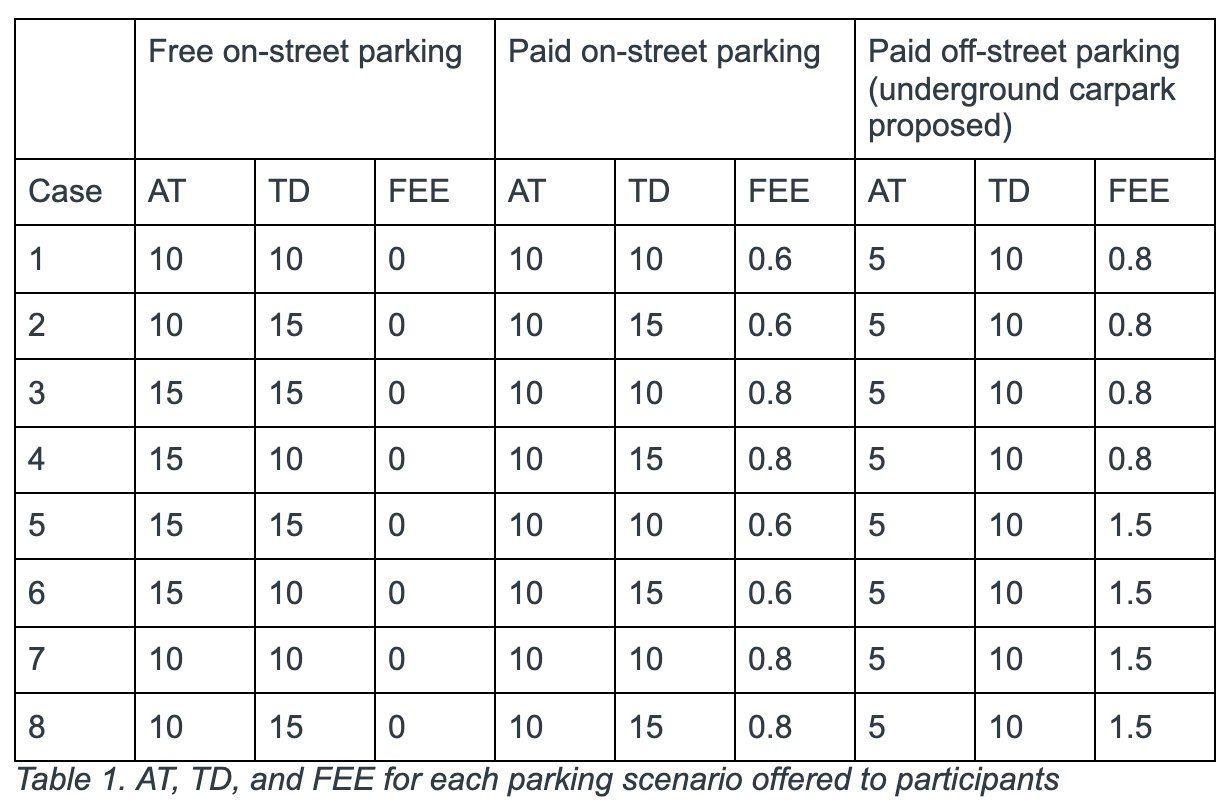


A full description of the dataset is listed below.

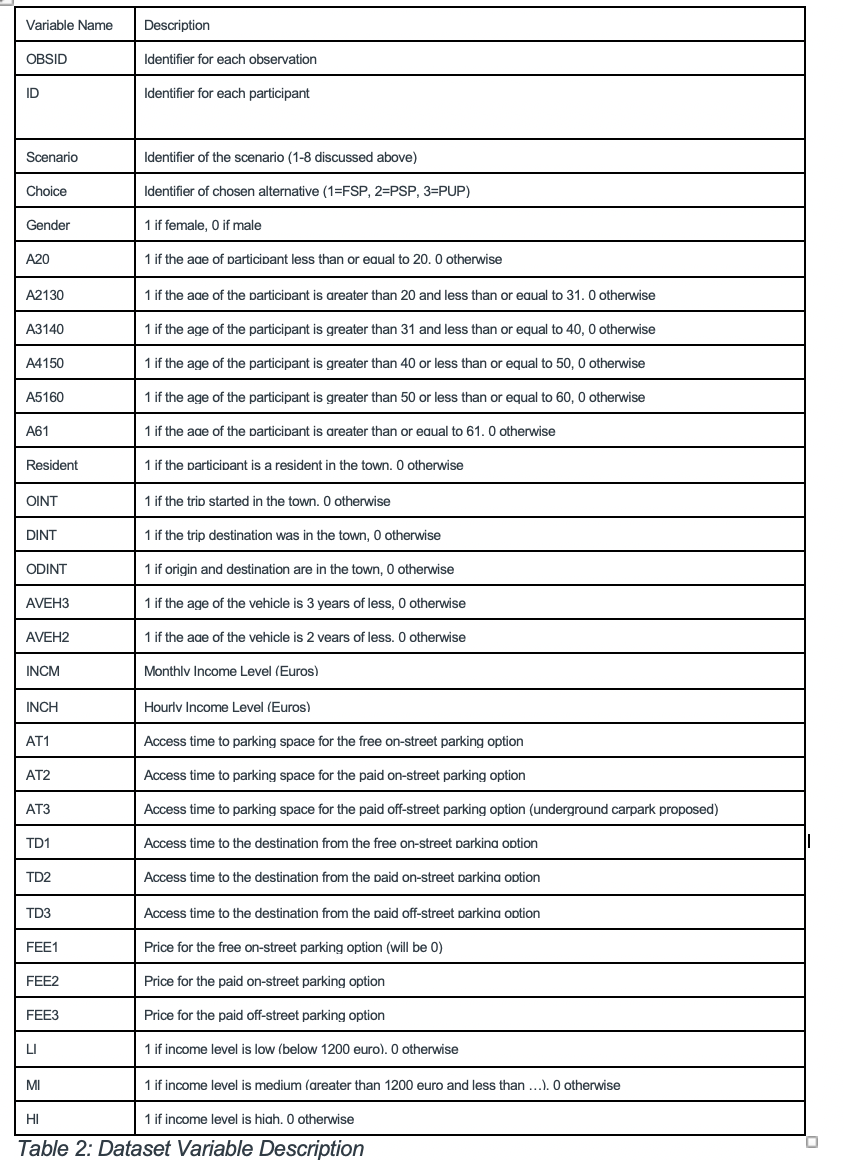

Given the purpose of the study, we have devised a few research questions to assist the regional government and private sector in evaluating how worthwhile the cost of a garage would be, and potential changes to the cost/location of underground carparks that might increase the utility of it for customers.

Our research questions will be:
- What are the main factors (in order) that contribute to the parking decision making process?
- What is the willingness to pay of individuals for parking per metre/per minute closer to the shopping centre?
- What are the marginal effects of cost for on-street vs off-street parking?
- What if on-street parking was located as close to the shops as off-street parking?
- What revenue can be extracted from off-street parking if 1000 people visited the town a day?
- How will choice probabilities change if off-street parking became cheaper than on-street parking?


Variable Creation (Distance)

---
---
##Section 2 || Exploratory Data Analysis

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import data
parking = pd.read_csv('http://transp-or.epfl.ch/data/parking.dat', sep='\t')


In [ ]:
walking_speed = (5.15) / 60
# Access Distance
parking['AD1'] = parking['AT1'] * walking_speed
parking['AD2'] = parking['AT2'] * walking_speed
parking['AD3'] = parking['AT3'] * walking_speed

# Destination Distance
parking['DD1'] = parking['TD1'] * walking_speed
parking['DD2'] = parking['TD2'] * walking_speed
parking['DD3'] = parking['TD3'] * walking_speed

parking.head()

,OBSID,ID,SCENARIO,CHOICE,GENDER,A20,A2130,A3140,A4150,A5160,A61,RESIDENT,OINT,DINT,ODINT,AVEH3,AVEH2,INCM,INCH,AT1,AT2,AT3,TD1,TD2,TD3,FEE1,FEE2,FEE3,LI,MI,HI,AD1,AD2,AD3,DD1,DD2,DD3
0,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,10,10,5,10,10,10,0,0.6,0.8,1,0,0,0.858333,0.858333,0.429167,0.858333,0.858333,0.858333
1,2,1,2,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,10,10,5,15,15,10,0,0.6,0.8,1,0,0,0.858333,0.858333,0.429167,1.287500,1.287500,0.858333
2,3,1,3,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,15,10,10,0,0.8,0.8,1,0,0,1.287500,0.858333,0.429167,1.287500,0.858333,0.858333
3,4,1,4,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,10,15,10,0,0.8,0.8,1,0,0,1.287500,0.858333,0.429167,0.858333,1.287500,0.858333
4,5,1,5,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,15,10,10,0,0.6,1.5,1,0,0,1.287500,0.858333,0.429167,1.287500,0.858333,0.858333


Firstly, our group decided to print a descpritive statistic output to gain a broad understanding of the variables in the dataset, and the ranges of numerical variables that we are working within. 


*Alternative Specific Characteristics*

From the output, the characteristics of each option were assessed:
- AT: The access time to parking once arriving at the destination was an average of 12.5mins for free parking, 10 mins for paid on street parking, and 5 minutes for underground paid parking. 
- TD: The time to destination was on average the same for both on-street options (12.5 mins), which was 2.5 minutes greater than the average time to destination for paid underground parking off-street (10 minutes).
- FEE: The fee was free for the free on-street parking, and averaged $\$12.50$ for paid on street and $10.00 for paid off-street parking.

Thus, while free on-street parking is quite obviously the cheapest option, and the time to destination is the same as paid on-street parking, it takes 2.5 minutes longer to find a park on average compared to paid street parking and 5 minutes longer than underground parking. Underground parking, interestingly, is cheaper than paid on-street parking by $2.50 an hour, and is generally located closer to the destination by an average of 2.5 minutes compared to other options. Underground parking also has a much smaller access time to find a park at only 5 minutes on average. 

*Income*

Income is the only other characteristic that is numerical that can be meaningfully assessed in the descriptive output. We note that while the monthly income has a mean of $\$1172.59$, the median is $900 and thus the distribution is negatively skewed with the majority of incomes sitting in the middle and high income range. 

In [ ]:
parking.describe()

,OBSID,ID,SCENARIO,CHOICE,GENDER,A20,A2130,A3140,A4150,A5160,A61,RESIDENT,OINT,DINT,ODINT,AVEH3,AVEH2,INCM,INCH,AT1,AT2,AT3,TD1,TD2,TD3,FEE1,FEE2,FEE3,LI,MI,HI,AD1,AD2,AD3,DD1,DD2,DD3
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.0,1576.0,1576.000000,1576.000000,1576.0,1576.0,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000,1.576000e+03,1.576000e+03,1576.000000,1576.000000,1.576000e+03
mean,788.500000,101.116751,4.500000,1.890228,0.269036,0.050761,0.248731,0.248731,0.187817,0.152284,0.065990,0.532995,0.446701,0.837563,0.314721,0.375635,0.274112,1172.588832,7.328680,12.500000,10.0,5.0,12.500000,12.500000,10.0,0.0,0.700000,1.150000,0.700508,0.203046,0.096447,1.072917,8.583333e-01,4.291667e-01,1.072917,1.072917,8.583333e-01
std,455.096327,57.897745,2.292015,0.971338,0.443599,0.219580,0.432415,0.432415,0.390690,0.359410,0.248343,0.499069,0.497309,0.368968,0.464552,0.484440,0.446207,763.856480,4.774103,2.500794,0.0,0.0,2.500794,2.500794,0.0,0.0,0.100032,0.350111,0.458181,0.402394,0.295297,0.214651,1.110575e-14,5.552877e-15,0.214651,0.214651,1.110575e-14
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,1.875000,10.000000,10.0,5.0,10.000000,10.000000,10.0,0.0,0.600000,0.800000,0.000000,0.000000,0.000000,0.858333,8.583333e-01,4.291667e-01,0.858333,0.858333,8.583333e-01
25%,394.750000,51.000000,2.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,900.000000,5.625000,10.000000,10.0,5.0,10.000000,10.000000,10.0,0.0,0.600000,0.800000,0.000000,0.000000,0.000000,0.858333,8.583333e-01,4.291667e-01,0.858333,0.858333,8.583333e-01
50%,788.500000,101.000000,4.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,900.000000,5.625000,12.500000,10.0,5.0,12.500000,12.500000,10.0,0.0,0.700000,1.150000,1.000000,0.000000,0.000000,1.072917,8.583333e-01,4.291667e-01,1.072917,1.072917,8.583333e-01
75%,1182.250000,151.000000,6.250000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1800.000000,11.250000,15.000000,10.0,5.0,15.000000,15.000000,10.0,0.0,0.800000,1.500000,1.000000,0.000000,0.000000,1.287500,8.583333e-01,4.291667e-01,1.287500,1.287500,8.583333e-01
max,1576.000000,201.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3000.000000,18.750000,15.000000,10.0,5.0,15.000000,15.000000,10.0,0.0,0.800000,1.500000,1.000000,1.000000,1.000000,1.287500,8.583333e-01,4.291667e-01,1.287500,1.287500,8.583333e-01


We also conduct data pre-processing to check for nulls, and the data types of each variable. All variables are integers except for the hourly wage (INCH), and the price of each alternative parking option (FEE2, FEE3). Further, the majority of variables are categorical apart from income (INCH, INCM), and the scenario characteristics (AT, FEE, TD). This will impact the interpretation of parameters in our model, as well as for the potential transformations that we intend to conduct.

In [ ]:
parking .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   OBSID     1576 non-null   int64  
 1   ID        1576 non-null   int64  
 2   SCENARIO  1576 non-null   int64  
 3   CHOICE    1576 non-null   int64  
 4   GENDER    1576 non-null   int64  
 5   A20       1576 non-null   int64  
 6   A2130     1576 non-null   int64  
 7   A3140     1576 non-null   int64  
 8   A4150     1576 non-null   int64  
 9   A5160     1576 non-null   int64  
 10  A61       1576 non-null   int64  
 11  RESIDENT  1576 non-null   int64  
 12  OINT      1576 non-null   int64  
 13  DINT      1576 non-null   int64  
 14  ODINT     1576 non-null   int64  
 15  AVEH3     1576 non-null   int64  
 16  AVEH2     1576 non-null   int64  
 17  INCM      1576 non-null   int64  
 18  INCH      1576 non-null   float64
 19  AT1       1576 non-null   int64  
 20  AT2       1576 non-null   int6

*Target Variable*

To begin our exploration of the variables, we decided to look at the most commonly chosen alternative over all participants and scenarios. This was the first option, which was the free option, and was chosen 53.24% of the time. The off-street parking option was the second most popular, being chosen 42.26% of the time, and this is expected given that it was on average cheaper and had lower access times to destination and to find a park than the paid on-street parking options. Lastly, paid-street parking was the least popular option, being chosen 4.51% of the time. This unbalanced classification task brings the risk of overfitting to the classes that are represented at a greater rate in the choice variable. This will be a limitation on the effectiviness of our models that we will need to mitigate.


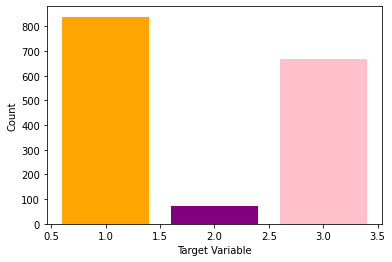

FSP:  53.236040609137056
PSP:  4.50507614213198
PUP:  42.25888324873097


In [ ]:
counts = parking["CHOICE"].value_counts()
plt.bar(counts.index, counts.values, color=["orange", "pink", "purple", "red"])
plt.ylabel("Count")
plt.xlabel("Target Variable")
plt.show()

print("FSP: ", len(parking.loc[parking["CHOICE"]==1])/len(parking['CHOICE'])*100)
print("PSP: ", len(parking.loc[parking["CHOICE"]==2])/len(parking['CHOICE'])*100)
print("PUP: ", len(parking.loc[parking["CHOICE"]==3])/len(parking['CHOICE'])*100)

*Income Effect*

Next we look at the distribution of choices based on different individual characteristics. 

As can be seen in the histograms below, free parking was chosen at a majority for low income participants (as expected) at 60.05% of cases. This is quite different from middle income and high income participants who only chose free parking 34.69% and 42.67% of the time respectively. Paid street parking is quite common between all options below 7%, which is expected given its similar time to destination as free parking and only 2.5mins on average benefit in time spent finding a park.

However, paid underground parking goes up from 36.14% of choices in low income individuals to 58.43% and 52.63% of choices in middle income and high income individuals respectively. Clearly, the distribution of choices is similar for middle and high income drivers, however there is a major difference between low income and middle-high income drivers in choices, with a large emphasis on the free parking for the low income drivers. This could suggest that incomes at lower levels are more significant to utility when considering the price, and hence a logarithm transformation may be useful. As incomes increase, time spent finding a park and walking to the destination may become more important factors, given the preference for paid underground parking in the top two income brackets.

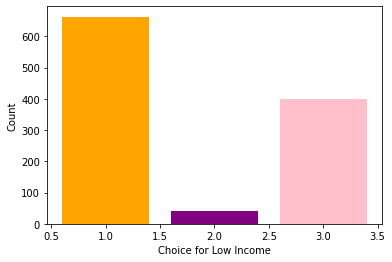

FSP:  60.05434782608695
PSP:  3.804347826086957
PUP:  36.141304347826086


In [ ]:
#low income choices
low_income=parking.loc[parking['LI']==1]

counts1 = low_income["CHOICE"].value_counts()
plt.bar(counts1.index, counts1.values, color=["orange", "pink", "purple", "red"])
plt.ylabel("Count")
plt.xlabel("Choice for Low Income")
plt.show()

print("FSP: ", len(low_income.loc[low_income["CHOICE"]==1])/len(low_income['CHOICE'])*100)
print("PSP: ", len(low_income.loc[low_income["CHOICE"]==2])/len(low_income['CHOICE'])*100)
print("PUP: ", len(low_income.loc[low_income["CHOICE"]==3])/len(low_income['CHOICE'])*100)

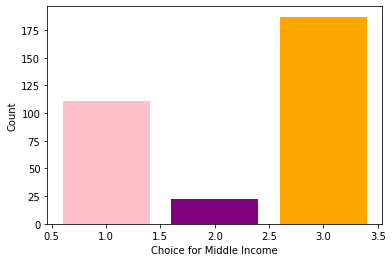

FSP:  34.6875
PSP:  6.875000000000001
PUP:  58.4375


In [ ]:
#middle income choices
middle_income=parking.loc[parking['MI']==1]

counts2 = middle_income["CHOICE"].value_counts()
plt.bar(counts2.index, counts2.values, color=["orange", "pink", "purple", "red"])
plt.ylabel("Count")
plt.xlabel("Choice for Middle Income")
plt.show()

print("FSP: ", len(middle_income.loc[middle_income["CHOICE"]==1])/len(middle_income['CHOICE'])*100)
print("PSP: ", len(middle_income.loc[middle_income["CHOICE"]==2])/len(middle_income['CHOICE'])*100)
print("PUP: ", len(middle_income.loc[middle_income["CHOICE"]==3])/len(middle_income['CHOICE'])*100)

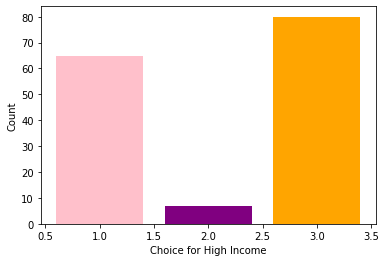

FSP:  42.76315789473684
PSP:  4.605263157894736
PUP:  52.63157894736842


In [ ]:
high_income=parking.loc[parking['HI']==1]

counts3 = high_income["CHOICE"].value_counts()
plt.bar(counts3.index, counts3.values, color=["orange", "pink", "purple", "red"])
plt.ylabel("Count")
plt.xlabel("Choice for High Income")
plt.show()

print("FSP: ", len(high_income.loc[high_income["CHOICE"]==1])/len(high_income['CHOICE'])*100)
print("PSP: ", len(high_income.loc[high_income["CHOICE"]==2])/len(high_income['CHOICE'])*100)
print("PUP: ", len(high_income.loc[high_income["CHOICE"]==3])/len(high_income['CHOICE'])*100)

*Age Effect*

Next, we look at the impact of age. It appears that the differences in choice between those above the age of 20, and below the age of 20, are not statistically significant. The differences are also quite minimal, and thus it appears it may not be a variable of interest for our models.

CHOICE    1   2    3
A20                 
0       793  70  633
1        46   1   33


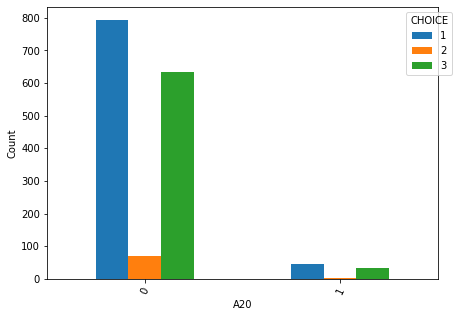

CHOICE        1         2         3
A20                                
0       0.53008  0.046791  0.423128
1       0.57500  0.012500  0.412500
A20
Stat: 2.2902705112701325
p value is 0.31818087912300186
Independent (H0 holds true)


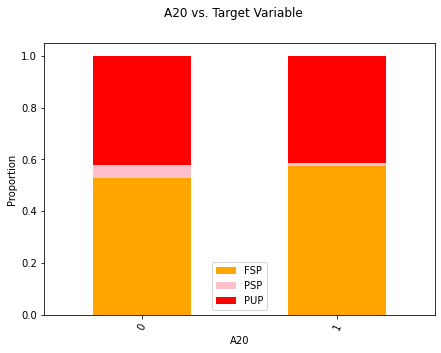

In [ ]:
categorical('A20', parking)

*Residency and Gender Effect*

Here we look at residency and gender. The difference in choices between resiodents and non-residents is evidently statistically significant, where the majority of choices switch from paid underground carpark for non-residents (49.46%) to free on-street parking for residents (60.60%). Hence, residency may form a valuable variable in our final model for its significant effect on utility between the alternatives.

CHOICE      1   2    3
RESIDENT              
0         330  42  364
1         509  29  302


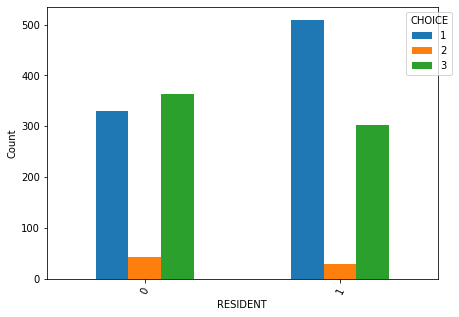

CHOICE           1         2         3
RESIDENT                              
0         0.448370  0.057065  0.494565
1         0.605952  0.034524  0.359524
RESIDENT
Stat: 39.651288502531386
p value is 2.4537601071941904e-09
Dependent (reject H0)


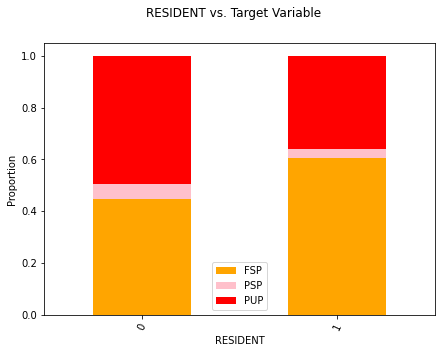

In [ ]:
categorical('RESIDENT',parking)

*Gender*

Gender effects on the choice outcome were deemed to create different choices that were statistically significant, however the differences in the proportion of choices between each group were small and thus it is unlikely that it will serve as a powerful variable for the determination of parking utility.

CHOICE    1   2    3
GENDER              
0       592  56  504
1       247  15  162


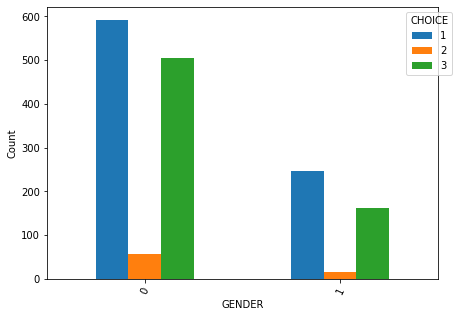

CHOICE         1         2         3
GENDER                              
0       0.513889  0.048611  0.437500
1       0.582547  0.035377  0.382075
GENDER
Stat: 6.202130072204948
p value is 0.045001248907250886
Dependent (reject H0)


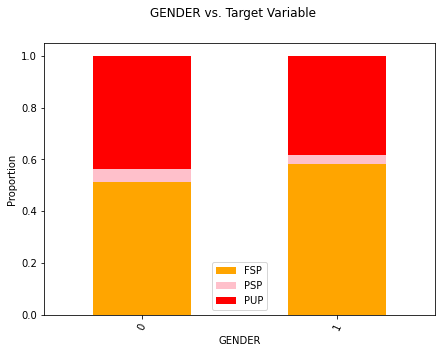

In [ ]:
categorical('GENDER',parking)

*Age of Car*

Similiar to gender, if the age of the car is less than or greater than 3 years yield statistically different results, however the changes are also relatively minimal. It still has the potential to serve as a predictor of utility in our model however as it significantly reduces the chances of choosing free on-street parking from 56% to 49%. 

CHOICE    1   2    3
AVEH3               
0       551  56  377
1       288  15  289


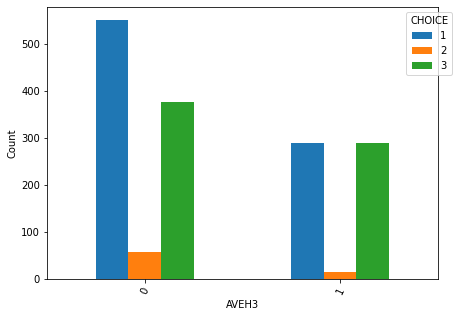

CHOICE         1         2         3
AVEH3                               
0       0.559959  0.056911  0.383130
1       0.486486  0.025338  0.488176
AVEH3
Stat: 21.578327360383497
p value is 2.06217610063613e-05
Dependent (reject H0)


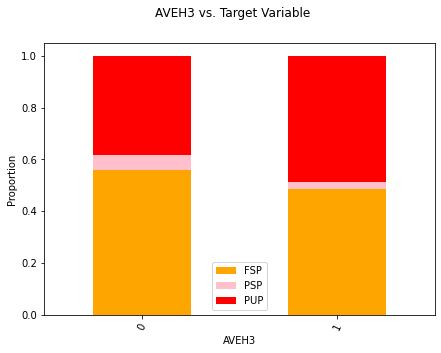

In [ ]:
categorical("AVEH3", parking)

*Origin of Trip*

The origin of the trip was not found to significantly affect choice outcomes.

CHOICE    1   2    3
OINT                
0       460  40  372
1       379  31  294


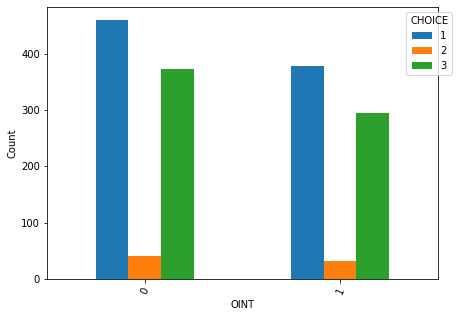

CHOICE         1         2         3
OINT                                
0       0.527523  0.045872  0.426606
1       0.538352  0.044034  0.417614
OINT
Stat: 0.18952827675762585
p value is 0.9095874459393359
Independent (H0 holds true)


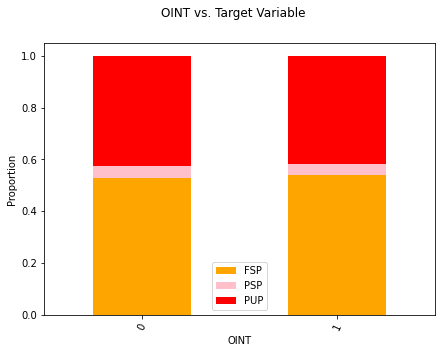

In [ ]:
categorical('OINT',parking)

*Correlation*

Now we also check the correlation with the outcome between all explanatory variables to see what is most important, as well as checking the correlation between variables. This assisted in conducting our baseline model building, whereby we ran a manual stepwise variable selection process that added variables first based on their strength of correlation with the outcome. 

The strongest 3 correlations between variables and the choice outcome, in order, were as follows.

- Price of PUP (FEE3): Correlation of 0.425
- Low Income (LI): Correlation of 0.204
- Residency Status (RESIDENT): Correlation of 0.150

In [ ]:
parking.corr().round(3)['CHOICE'].sort_values()

FEE3       -0.425
SCENARIO   -0.389
LI         -0.204
RESIDENT   -0.150
A4150      -0.106
DINT       -0.080
A2130      -0.077
ODINT      -0.058
GENDER     -0.057
FEE2       -0.046
A20        -0.013
OINT       -0.010
DD3         0.000
AD2         0.000
AD3         0.000
DD2         0.011
TD2         0.011
A3140       0.021
DD1         0.027
TD1         0.027
AVEH2       0.033
AD1         0.058
AT1         0.058
A61         0.062
HI          0.070
AVEH3       0.089
A5160       0.112
OBSID       0.133
ID          0.135
INCH        0.181
INCM        0.181
MI          0.181
CHOICE      1.000
AT2           NaN
AT3           NaN
TD3           NaN
FEE1          NaN
Name: CHOICE, dtype: float64

The strongest cases for multicollinearity would exist between residency and origin of trip, however this was not an issue as the origin of trip was not a variable we were interested in using (0.514 for OINT and RESIDENT). Age and income also represented a case for multicollinearity (0.228 for A20 and INCM), however age was not a variable of interest.

In [ ]:
parking.corr().round(3)

,OBSID,ID,SCENARIO,CHOICE,GENDER,A20,A2130,A3140,A4150,A5160,A61,RESIDENT,OINT,DINT,ODINT,AVEH3,AVEH2,INCM,INCH,AT1,AT2,AT3,TD1,TD2,TD3,FEE1,FEE2,FEE3,LI,MI,HI,AD1,AD2,AD3,DD1,DD2,DD3
OBSID,1.000,1.000,0.005,0.133,0.009,0.063,0.030,0.004,-0.168,0.135,-0.000,0.108,0.056,-0.061,0.051,0.164,0.181,-0.017,-0.017,0.000,NaN,NaN,0.000,0.001,NaN,NaN,0.002,0.004,-0.078,0.146,-0.078,-0.000,0.0,0.0,0.000,0.001,0.0
ID,1.000,1.000,-0.000,0.135,0.008,0.063,0.029,0.002,-0.169,0.136,0.001,0.108,0.055,-0.060,0.051,0.163,0.180,-0.017,-0.017,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,0.000,-0.079,0.147,-0.079,-0.000,0.0,0.0,-0.000,-0.000,0.0
SCENARIO,0.005,-0.000,1.000,-0.389,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.218,NaN,NaN,0.436,0.873,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.218,0.0
CHOICE,0.133,0.135,-0.389,1.000,-0.057,-0.013,-0.077,0.021,-0.106,0.112,0.062,-0.150,-0.010,-0.080,-0.058,0.089,0.033,0.181,0.181,0.058,NaN,NaN,0.027,0.011,NaN,NaN,-0.046,-0.425,-0.204,0.181,0.070,0.058,0.0,0.0,0.027,0.011,0.0
GENDER,0.009,0.008,-0.000,-0.057,1.000,-0.036,0.075,0.181,0.001,-0.162,-0.115,0.086,0.007,-0.012,-0.017,-0.163,-0.142,-0.158,-0.158,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,0.000,0.222,-0.221,-0.043,-0.000,-0.0,-0.0,-0.000,-0.000,-0.0
A20,0.063,0.063,0.000,-0.013,-0.036,1.000,-0.133,-0.133,-0.111,-0.098,-0.061,-0.015,-0.115,0.102,-0.057,0.012,0.065,-0.228,-0.228,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,-0.000,0.151,-0.117,-0.076,-0.000,-0.0,-0.0,-0.000,-0.000,-0.0
A2130,0.030,0.029,0.000,-0.077,0.075,-0.133,1.000,-0.331,-0.277,-0.244,-0.153,0.115,0.097,0.031,0.141,0.063,0.015,-0.150,-0.150,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,-0.000,0.171,-0.115,-0.108,-0.000,-0.0,-0.0,-0.000,-0.000,-0.0
A3140,0.004,0.002,0.000,0.021,0.181,-0.133,-0.331,1.000,-0.277,-0.244,-0.153,-0.003,0.026,-0.192,-0.137,0.014,0.041,-0.072,-0.072,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,-0.000,0.043,0.060,-0.148,-0.000,-0.0,-0.0,-0.000,-0.000,-0.0
A4150,-0.168,-0.169,-0.000,-0.106,0.001,-0.111,-0.277,-0.277,1.000,-0.204,-0.128,-0.019,0.065,0.000,0.038,-0.078,-0.033,0.114,0.114,0.000,NaN,NaN,0.000,0.000,NaN,NaN,-0.000,0.000,-0.026,-0.049,0.107,-0.000,-0.0,-0.0,-0.000,-0.000,-0.0
A5160,0.135,0.136,-0.000,0.112,-0.162,-0.098,-0.244,-0.244,-0.204,1.000,-0.113,0.000,-0.068,0.072,0.047,0.109,0.120,0.271,0.271,0.000,NaN,NaN,0.000,0.000,NaN,NaN,0.000,-0.000,-0.278,0.208,0.149,0.000,0.0,0.0,0.000,0.000,0.0


---
---

#Section 3 || Model Building


##Base Model
Firstly, we begin with a base multinomial logit model that predicts the choice based on a variety of variables deemed strongest through our exploratory analysis, which included tests for statistical significance with relation to the choice outcome and analysed strength of correlation with the choice outcome.

In [ ]:
bgm_parking = db.Database('parking', parking)

In [ ]:
parking.head()

,OBSID,ID,SCENARIO,CHOICE,GENDER,A20,A2130,A3140,A4150,A5160,A61,RESIDENT,OINT,DINT,ODINT,AVEH3,AVEH2,INCM,INCH,AT1,AT2,AT3,TD1,TD2,TD3,FEE1,FEE2,FEE3,LI,MI,HI,AD1,AD2,AD3,DD1,DD2,DD3
0,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,10,10,5,10,10,10,0,0.6,0.8,1,0,0,0.858333,0.858333,0.429167,0.858333,0.858333,0.858333
1,2,1,2,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,10,10,5,15,15,10,0,0.6,0.8,1,0,0,0.858333,0.858333,0.429167,1.287500,1.287500,0.858333
2,3,1,3,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,15,10,10,0,0.8,0.8,1,0,0,1.287500,0.858333,0.429167,1.287500,0.858333,0.858333
3,4,1,4,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,10,15,10,0,0.8,0.8,1,0,0,1.287500,0.858333,0.429167,0.858333,1.287500,0.858333
4,5,1,5,1,1,0,1,0,0,0,0,1,0,1,0,0,0,900,5.625,15,10,5,15,10,10,0,0.6,1.5,1,0,0,1.287500,0.858333,0.429167,1.287500,0.858333,0.858333


In this step, we decided to transform the income variable through a log transformation for the evidence that suggested low incomes were more impactful to the utility calculation of parking options than middle and high incomes. We then conduct our split of the dataset into a train (75%) and test (25%) dataset so that our accuracy calculations could be completed on the test set. This will enable us to analyse the predictive power of the model on unseen data for a more robust measure of effectiveness, taking into account the potential for overfitting the unbalanced outcomes.

In [ ]:
#log_income = parking['log_income']
parking['log_income'] = np.log(parking['INCM'])

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
parking_train, parking_test = train_test_split(parking, test_size = 0.25, random_state = 3840)

Next we update the globals using our auxiliary function

In [ ]:
#update globals
qbus_update_globals_bgm(parking_train)

*Model Building* 

We then established a range of parameters for the baseline model which we used in conjunction with the following step to conduct a stepwise variable selection which selected the model with the highest accuracy out of the combination of our most significant variables identified in the exploratory analysis. This was conduct to both decrease the computational costs of computing a best subset selection, whilst still ensuring a strong baseline model for our multinomial logit to improve upon. We also establish alternative specific constants, chosing paid underground parking as our reference by setting the constant to 0. 

In [ ]:
#establish parameters for baseline model
ASC_FSP = exp.Beta ( 'ASC_FSP' ,0, None , None ,0)
ASC_PSP = exp.Beta ( 'ASC_PSP' ,0, None , None ,0)
ASC_PUP = exp.Beta ( 'ASC_PUP' ,0, None , None ,1)

B_FEE_FSP = exp.Beta ( 'B_FEE_FSP' ,0, None , None ,0)
B_FEE_PSP = exp.Beta ( 'B_FEE_PSP' ,0, None , None ,0)
B_FEE_PUP = exp.Beta ( 'B_FEE_PUP' ,0, None , None ,0)

B_income_FSP = exp.Beta ( 'B_income_FSP' ,0, None , None ,0)
B_income_PSP = exp.Beta ( 'B_income_PSP' ,0, None , None ,0)
B_income_PUP = exp.Beta ( 'B_income_PUP' ,0, None , None ,0)

B_resident_FSP = exp.Beta ( 'B_resident_FSP' ,0, None , None ,0)
B_resident_PSP = exp.Beta ( 'B_resident_PSP' ,0, None , None ,0)
B_resident_PUP = exp.Beta ( 'B_resident_PUP' ,0, None , None ,0)

B_agecar_FSP = exp.Beta ( 'B_agecar_FSP' ,0, None , None ,0)
B_agecar_PSP = exp.Beta ( 'B_agecar_PSP' ,0, None , None ,0)
B_agecar_PUP = exp.Beta ( 'B_agecar_PUP' ,0, None , None ,0)

B_AT_FSP = exp.Beta ( 'B_AT_FSP' ,0, None , None ,0)
B_AT_PSP = exp.Beta ( 'B_AT_PSP' ,0, None , None ,0)
B_AT_PUP = exp.Beta ( 'B_AT_PUP' ,0, None , None ,0)

B_AD_FSP = exp.Beta ( 'B_AD_FSP' ,0, None , None ,0)
B_AD_PSP = exp.Beta ( 'B_AD_PSP' ,0, None , None ,0)
B_AD_PUP = exp.Beta ( 'B_AD_PUP' ,0, None , None ,0)

B_TD_FSP = exp.Beta ( 'B_TD_FSP' ,0, None , None ,0)
B_TD_PSP = exp.Beta ( 'B_TD_PSP' ,0, None , None ,0)
B_TD_PUP = exp.Beta ( 'B_TD_PUP' ,0, None , None ,0)

B_TD_FSP = exp.Beta ( 'B_TD_FSP' ,0, None , None ,0)
B_TD_PSP = exp.Beta ( 'B_TD_PSP' ,0, None , None ,0)
B_TD_PUP = exp.Beta ( 'B_TD_PUP' ,0, None , None ,0)

B_DD_FSP = exp.Beta ( 'B_DD_FSP' ,0, None , None ,0)
B_DD_PSP = exp.Beta ( 'B_DD_PSP' ,0, None , None ,0)
B_DD_PUP = exp.Beta ( 'B_DD_PUP' ,0, None , None ,0)

B_LI_FSP = exp.Beta ( 'B_LI_FSP' ,0, None , None ,0)
B_LI_PSP = exp.Beta ( 'B_LI_PSP' ,0, None , None ,0)
B_LI_PUP = exp.Beta ( 'B_LI_PUP' ,0, None , None ,0)

B_gender_FSP = exp.Beta ( 'B_gender_FSP' ,0, None , None ,0)
B_gender_PSP = exp.Beta ( 'B_gender_PSP' ,0, None , None ,0)
B_gender_PUP = exp.Beta ( 'B_gender_PUP' ,0, None , None, 0)
                         


Here, we define the best baseline as a multinomial whereby variables have been added based on increasing the accuracy on the test dataset the most. These were intuitively selected from having the highest correlation with the choice variable, starting with fee and income as a log transformation for showing higher significance at lower incomes. Categorical variables for resident and age of car 3 years or less were also relevant to increasing the amount of choice variation captured in the baseline, despite the age of car demonstrating smaller effects in the exploratory data analysis. These were also checked for multicollinearity issues.

In [ ]:
V_FSP = ASC_FSP + B_FEE_FSP*FEE1 + B_income_FSP*log_income + B_resident_FSP*RESIDENT + B_agecar_FSP*AVEH3
V_PSP = ASC_PSP + B_FEE_PSP*FEE2 + B_income_PSP*log_income + B_resident_PSP*RESIDENT + B_agecar_PSP*AVEH3
V_PUP = ASC_PUP + B_FEE_PUP*FEE3 + B_income_PUP*log_income + B_resident_PUP*RESIDENT + B_agecar_PUP*AVEH3
V_base = {1: V_FSP, 2: V_PSP,3: V_PUP}


The following step uses our auxiliary functions to estimate the model on the train dataset.

In [ ]:
model_baseline, results_baseline = qbus_estimate_bgm(V_base, parking_train, 'CHOICE', 'parking')

results_baseline.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_FSP,1.499805,7.371644e-01,2.034560,4.189519e-02,7.820960e-01,1.917674,5.515240e-02
ASC_PSP,3.067681,2.303246e+00,1.331895,1.828948e-01,2.447078e+00,1.253610,2.099839e-01
B_FEE_FSP,0.000000,6.977714e-14,0.000000,1.000000e+00,7.381088e-14,0.000000,1.000000e+00
B_FEE_PSP,-13.386448,2.626601e+00,-5.096492,3.460059e-07,2.612692e+00,-5.123623,2.997206e-07
B_FEE_PUP,-3.194064,2.068755e-01,-15.439545,0.000000e+00,2.086558e-01,-15.307815,0.000000e+00
B_agecar_FSP,0.196941,1.362035e-01,1.445933,1.481961e-01,1.394800e-01,1.411966,1.579600e-01
B_agecar_PSP,-0.745514,2.365436e-01,-3.151698,1.623241e-03,2.362712e-01,-3.155331,1.603160e-03
B_agecar_PUP,0.548573,1.410700e-01,3.888656,1.008008e-04,1.387680e-01,3.953165,7.712408e-05
B_income_FSP,-0.509285,8.902874e-02,-5.720458,1.062370e-08,8.870209e-02,-5.741525,9.382786e-09
B_income_PSP,0.272199,1.497962e-01,1.817126,6.919782e-02,1.407969e-01,1.933272,5.320273e-02


*Results*

First, we retrieve our parameters to identify the characteristics of our model. 

* *The relative order for the ASCs is interestingly very different from the baseline. When fee, age of car, income and residency is held constant, the underground carpark has the lowest utility, followed by the free street parking and lastly the paid-street parking.*
* *The fee of paid street parking has the highest negative impact on utility (-13.39) for a one dollar increase in price, which is much higher than the paid underground parking option (-3.19). This could be explained by the risks of leaving your car on the street whilst also entailing higher time to destination and access time than the PUP option*
* *Being a resident will increase your utility for free-street parking options (0.52 utils on average), whilst decreasing your utility for the paid street parking option the most (0.33 utils on average). Being a resident also decreases your utility for paid underground parking, but by less than the paid street parking option (only -0.19 utils on average). Clearly, residents are more willing to use free parking options, and much less likely to pay for the on-street options.*
* *As income (log_income) increases, the utility derived for the free-street parking decreases (-0.51) as revealed in the EDA, where preferences for shorter time to destination and finding a park are valued more. Interestingly, higher incomes will increase the paid street-parking option utility by 0.27 on average, which is slightly more than the paid underground carpark utility. The largest effect is on the free on-street parking, which confirms our suspicion that lower incomes are very significant to choosing the free parking option.*
* *The age of the car, if less than 3 years, will have the largest negative effect on utility for the paid on-street option (-0.75 utils on average) whilst increasing utility for the free street parking (0.20 utils on average) and paid underground carpark (0.55 utils on average). This reflects the preference for safety in the underground carpark over a street park, which is expected. However, the increase in utility for free street parking may be explained by the fact that a recent purchase increases the utility of saving money by using the free option*

In [ ]:
#analyse model
results_baseline.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_FSP,1.499805,7.371644e-01,2.034560,4.189519e-02,7.820960e-01,1.917674,5.515240e-02
ASC_PSP,3.067681,2.303246e+00,1.331895,1.828948e-01,2.447078e+00,1.253610,2.099839e-01
B_FEE_FSP,0.000000,6.977714e-14,0.000000,1.000000e+00,7.381088e-14,0.000000,1.000000e+00
B_FEE_PSP,-13.386448,2.626601e+00,-5.096492,3.460059e-07,2.612692e+00,-5.123623,2.997206e-07
B_FEE_PUP,-3.194064,2.068755e-01,-15.439545,0.000000e+00,2.086558e-01,-15.307815,0.000000e+00
B_agecar_FSP,0.196941,1.362035e-01,1.445933,1.481961e-01,1.394800e-01,1.411966,1.579600e-01
B_agecar_PSP,-0.745514,2.365436e-01,-3.151698,1.623241e-03,2.362712e-01,-3.155331,1.603160e-03
B_agecar_PUP,0.548573,1.410700e-01,3.888656,1.008008e-04,1.387680e-01,3.953165,7.712408e-05
B_income_FSP,-0.509285,8.902874e-02,-5.720458,1.062370e-08,8.870209e-02,-5.741525,9.382786e-09
B_income_PSP,0.272199,1.497962e-01,1.817126,6.919782e-02,1.407969e-01,1.933272,5.320273e-02


After retrieving the parameters, we are able to see how much variation in the choice outcome for the train dataset that we are able to capture with this model. The accuracy of predictions is 70.89% which is an improvement on naive prediction of FSP for each choice which would yield 52.79% (revealed in the value counts calculation below). The confusion matrix demonstrates that the model never predicts paid street parking, which indicates the baseline potentially overfits to the other choice options which are chosen at higher rates. This is an opportunity for improvement in the more complex models.

In [ ]:
#calculation of choice probabilities, as well as the resulting predictions, accuracy and confusion matrix.
prob_preds = qbus_simulate_bgm(model_baseline, results_baseline.getBetaValues(), parking_train)
accu, conf_mat = qbus_calc_accu_confusion(prob_preds, parking_train, 'CHOICE')
accu

0.7089678510998308

In [ ]:
#naive model
parking_train['CHOICE'].value_counts(normalize=True)

1    0.527919
3    0.425550
2    0.046531
Name: CHOICE, dtype: float64

In [ ]:
conf_mat

Predicted,1,3
Actual,,
1,463,161
2,51,4
3,128,375


As used for our stepwise variable selection process, the test accuracy was also calculated using our auxiliary functions. Again, the model never predicts paid street parking. The accuracy on the holdout dataset is 68.27%, which is an improvement on 54.57% naive model.

In [ ]:

#calculation of test acccuracy and confusion matrix
sim_test = qbus_simulate_bgm(model_baseline, results_baseline.getBetaValues(),parking_test)
qbus_calc_accu_confusion(sim_test, parking_test, 'CHOICE')

(0.682741116751269, Predicted    1    3
 Actual             
 1          144   71
 2           16    0
 3           38  125)

In [ ]:
#naive model
parking_test['CHOICE'].value_counts(normalize=True)

1    0.545685
3    0.413706
2    0.040609
Name: CHOICE, dtype: float64

In [ ]:
V1_FSP = ASC_FSP + B_FEE_FSP*FEE1 + B_income_FSP*log_income + B_resident_FSP*RESIDENT + B_agecar_FSP*AVEH3 + B_AD_FSP*AD1 + B_DD_FSP*DD1
V1_PSP = ASC_PSP + B_FEE_PSP*FEE2 + B_income_PSP*log_income + B_resident_PSP*RESIDENT + B_agecar_PSP*AVEH3 + B_AD_PSP*AD2 + B_DD_PSP*DD2
V1_PUP = ASC_PUP + B_FEE_PUP*FEE3 + B_income_PUP*log_income + B_resident_PUP*RESIDENT + B_agecar_PUP*AVEH3 + B_AD_PUP*AD3 + B_DD_PUP*DD3
V1_base = {1: V1_FSP, 2: V1_PSP,3: V1_PUP}


In [ ]:
distance_model, distance_results = qbus_estimate_bgm(V1_base, parking_train, 'CHOICE', 'parking')

distance_results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_FSP,2.055156,7.301584e-01,2.814672,4.882711e-03,7.472374e-01,2.750339,5.953365e-03
ASC_PSP,3.466073,1.101778e+00,3.145892,1.655810e-03,1.137499e+00,3.047100,2.310608e-03
B_AD_FSP,-1.070362,3.232270e-01,-3.311488,9.280138e-04,3.230348e-01,-3.313458,9.215011e-04
B_AD_PSP,0.341953,9.456924e-01,0.361591,7.176580e-01,9.763533e-01,0.350235,7.261621e-01
B_AD_PUP,-0.409315,3.053496e-01,-1.340480,1.800895e-01,3.193942e-01,-1.281535,2.000057e-01
B_DD_FSP,-0.164090,3.208719e-01,-0.511389,6.090790e-01,3.219573e-01,-0.509665,6.102865e-01
B_DD_PSP,-2.227894,7.470385e-01,-2.982301,2.860907e-03,7.114884e-01,-3.131314,1.740260e-03
B_DD_PUP,-0.818630,6.106992e-01,-1.340480,1.800895e-01,6.387884e-01,-1.281535,2.000057e-01
B_FEE_FSP,0.000000,1.797693e+308,0.000000,1.000000e+00,1.797693e+308,0.000000,1.000000e+00
B_FEE_PSP,-12.431158,2.653360e+00,-4.685062,2.798749e-06,2.622106e+00,-4.740906,2.127650e-06


We calculated the willingness of customers to pay for parking spots based on their proximity to arrival and destination locations (per kilometer). We can see immediately that customers opting for paid underground parking are more willing to pay for parking spots that are conveniently located. Further findings are discussed in the discussion section of this report.

In [ ]:
betas = distance_results.getBetaValues()
betas['B_AD_PSP'] / betas['B_FEE_PSP']

-0.02750777104015063

In [ ]:
betas['B_DD_PSP'] / betas['B_FEE_PSP']

0.17921851186371326

In [ ]:
betas['B_AD_PUP'] / betas['B_FEE_PUP']

0.12891284937204706

In [ ]:
betas['B_DD_PUP'] / betas['B_FEE_PUP']

0.2578256987440941

# Neural Net

One of the additional models explored in this report was the recurrent neural network (RNN) model. This form of neural network model is a popular choice in a wide variety of deep learning tasks including; text analysis; speech recognition, and; consumer choice analysis. We anticipated this model would perform well given the task addressed in this report. The RNN model is built using packages from Tensorflow, as a preliminary step these must be imported.

In [ ]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Parameters and some hyperparameters are defined, the target data is isolated from the remainder of th dataset - the data is prepared for modelling through Keras. The MAXLEN and shape variables encode the number of observations the model learns from in each iteration and the shape variable encodes the size of vector the data is adjusted to in the 'Flatten' layer of the RNN model. These hyperparameters were adjusted to optimise model accuracy. 

In [ ]:
MAXLEN=10

x_train = parking_train.drop(columns='CHOICE')
y_train = parking_train['CHOICE']

x_test = parking_test.drop(columns='CHOICE')
y_test = parking_test['CHOICE']

shape = x_train.shape[1]

The model is subsequently built from encoded keras layers of various sizes and types. The combination of layers shown below was found to perform optimally in terms of test accuracy. Dense layer sizes [60, 120, 240, 360, 540] were tested with various combinations of flatten and dropout layers. Ultimately, a relatively simple RNN model with two dense layers of sizes 360 and 120 respectively performed optimally in terms of test accuracy.

In [ ]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(shape,)),
  #tf.keras.layers.Dense(shape, activation='sigmoid'),
  tf.keras.layers.Dense(360, activation='sigmoid'),
  tf.keras.layers.Dense(120, activation='sigmoid'),
  #tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(60, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The model was built on the training data over 4 epochs, this was found to be the optimal number of epochs such that train accuracy was maximised wihtout causing a reduction in test accuracy due to overfitting.

In [ ]:
model.fit(x_train, y_train, epochs=4)
model.evaluate(x_test, y_test)

Epoch 1/4
37/37 [==============================] - 1s 3ms/step - loss: 1.5927 - accuracy: 0.4594
Epoch 2/4
37/37 [==============================] - 0s 3ms/step - loss: 0.8321 - accuracy: 0.5601
Epoch 3/4
37/37 [==============================] - 0s 3ms/step - loss: 0.8145 - accuracy: 0.5702
Epoch 4/4
13/13 [==============================] - 0s 2ms/step - loss: 0.7943 - accuracy: 0.5939


[0.794317901134491, 0.5939086079597473]

Our results show that despite our optimism about the performance of an RNN model, it was only able to achieve an accuracy of 57.6% on the test data. This model was the worst performing of those presented in this report. It was though that perhaps the inclusion of continuous variables was inhibiting the performance of the RNN model. However, no improvement was reported when continuous variables were removed from 'x_train'. One-hot encoding was one possible adjustment that was not explored in this report that might improve the performance of the RNN model. It is thought that there is an issue of data sparsity created by the continuous and discrete variables in this assignment's dataset that impedes the RNN model.

# Regressors with Variable Selection

It was decided in order to validate the selection of variables made for the logistic model, a series of forward selection models should be tested on the data. A library of regressive classification models that incorporate forward selection can be imported from SKLearn. Models were subsequently built using the training data, their test accuracy was reported to validate the decisions of each respective model.

In [ ]:
from sklearn import linear_model

###### Elastic Net

The elastic net model combines the L1 and L2 regularization techniques, creating strict conditions in which the model will heavily prioritise variables based on their usefulness to the model - particularly the L1 penalty function. As such, in an elastic net model most variables take on near 0 coefficient (beta) values. The remaining variables, with beta values of significant magnitudes, are therefore more significant to a regressive classification model.

In [ ]:
regr = linear_model.ElasticNet(random_state=0)
regr.fit(x_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

As expected, all of these forward selection models perform terribly on the dataset at hand (we see below an accuracy of only 13% for the elastic net model). However, the benefit of comparing the results of quantitative variable selection to our qualitative selection of variables in the logistic model is discussed in the discussion of our results.

In [ ]:
regr.score(x_test,y_test)

0.1333890495627964

This process of modelling was repeated on a variety of regressive classification models.

###### Elastic Net with Regularisation

Elastic net CV simply includes a cross validation (CV) algorithm into the process of modelling the data. Using the same regularisation technique as the elastic net model, it was arbitrarily decided that 5-fold CV was a suitable choice for the dataset (it is generally considered a fair choice for cross validation).

In [ ]:
regrcv = linear_model.ElasticNetCV(cv=5, random_state=0)
regrcv.fit(x_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [ ]:
regrcv.score(x_test,y_test)

0.19009917861816983

###### Lars CV

The least angle regressive (LARS) CV model performs a slightly different type of variable selection: initially setting all beta values to 0, the LARS modelling technique updates beta values based on their correlation to the target variable. The number of variables allowed to take on non-zero values can be pre-selected and has been set to 3 for the purpose of the research question addressed by this exercise.

In [ ]:
reg = linear_model.Lars(n_nonzero_coefs=1, normalize=False)
reg.fit(x_train, y_train)

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True,
     n_nonzero_coefs=1, normalize=False, precompute='auto', verbose=False)

In [ ]:
reg.score(x_test,y_test)

0.01694865021238534

###### Lasso

The lasso regressive classification model builds a model using the l1 regularisation technique, which takes the absolute value of the distance between predictions and their target. The advantage, in this case, of l1 regularisation is that it shrinks beta values to 0-values if they do not improve model performance.

In [ ]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.6501124343696, tolerance: 0.1114613367174281
  positive)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
clf.score(x_test,y_test)

0.2528572062043155

###### Lasso Lars

The Lasso Lars model combines the Least Angle Regression Model with an L1 penalty term.

In [ ]:
clfreg = linear_model.LassoLars(alpha=0.01, normalize=False)
clfreg.fit(x_train, y_train)

LassoLars(alpha=0.01, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=False,
          positive=False, precompute='auto', verbose=False)

In [ ]:
clfreg.score(x_test,y_test)

0.2532380138016984

###### Lasso Lars IC

The Lasso Lars IC model additionally incorporates an information criterion. We chose to present the Akaike information criterion (AIC), although Baye's information criterion (BIC) would equally be a suitable choice.

In [ ]:
clfregic = linear_model.LassoLarsIC(criterion='aic', normalize=False)
clfregic.fit(x_train,y_train)

LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=False, positive=False,
            precompute='auto', verbose=False)

In [ ]:
clfregic.score(x_test,y_test)

0.2523332051762245

### Comparison

In [ ]:
var_names = []

for col in x_train.columns:
    var_names.append(col)

col_names = ['Elastic Net','Elastic Net CV','Lars','Lasso','Lasso Lars','AIC Lasso Lars']
res = [regr.coef_, regrcv.coef_, reg.coef_, clf.coef_, clfreg.coef_, clfregic.coef_,]

varsele = pd.DataFrame(columns = var_names, index = col_names, data = res)
varsele.T

,Elastic Net,Elastic Net CV,Lars,Lasso,Lasso Lars,AIC Lasso Lars
OBSID,0.000284,0.000292,0.000000,-0.000006,-0.004498,-0.004109
ID,0.000000,0.000000,0.000000,0.002138,0.037458,0.034224
SCENARIO,-0.062962,-0.134949,0.000000,-0.071477,-0.066811,-0.031966
GENDER,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.083384
A20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2130,-0.000000,-0.000000,0.000000,-0.169707,-0.160478,-0.347627
A3140,0.000000,0.000000,0.000000,-0.030943,-0.018144,-0.224169
A4150,-0.000000,-0.000000,0.000000,-0.245206,-0.234106,-0.425100
A5160,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048269
A61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Decision Tree and Random Forrest





We attempt to find other machine learning models to obtain better accuracy rate. In this section, we developed Decision Tree and Random Forrest models. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# following code was taken from https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn and modified.

parameters = {'max_depth':range(3,30)}
gscv = GridSearchCV(tree.DecisionTreeClassifier(random_state=3840), parameters, cv=10)
gscv.fit(X=x_train, y=y_train)
tree_model = gscv.best_estimator_
print (gscv.best_score_, gscv.best_params_) 

0.8807648483122064 {'max_depth': 17}


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_features= None, max_depth= 17, random_state=3840 )

# Train the model on training data
dec_tree.fit(x_train, pd.get_dummies(y_train));

Different to the multinomial model where the variables selection is mannally performed, the Decision Tree model does it automatically. However, maximum depth of tree should be provided. In our model, max_depth of 17 is used as the result of GridSearchCV shows the max depth of 17 produces the best score. 

In [ ]:
# Use the predict method on the test data
predictions = dec_tree.predict(x_test)
dec_tree_sim = pd.DataFrame(predictions, columns=[1, 2, 3])
dec_tree_sim.index = parking_test.index

In [ ]:
qbus_calc_accu_confusion(dec_tree_sim, parking_test, 'CHOICE')

(0.9111675126903553, Predicted    1   2    3
 Actual                 
 1          201  10    4
 2            7   8    1
 3           12   1  150)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 3840, max_features= None)
rf.fit(x_train, pd.get_dummies(y_train));
predictions = rf.predict(x_test)
rf_sim = pd.DataFrame(predictions, columns=[1, 2, 3])
rf_sim.index = parking_test.index
qbus_calc_accu_confusion(rf_sim, parking_test, 'CHOICE')

(0.9111675126903553, Predicted    1  2    3
 Actual                
 1          207  2    6
 2            9  5    2
 3           16  0  147)

The accuracy of the Decision Tree model was 91.11% which is higher than the baseline model (68.27%). Random Forrest model was generated with 1000 decision trees and resulted similar accuracy to the Decision Tree, 91.11%. Although the Decision Tree and Random Forrest models achieved higher accuracy rate, one of limitation is that it is harder to interpret than the multinomial model. However, we can tell from the Decision Tree model which variable is important for the tree. 

In [ ]:
feat_import = pd.DataFrame(dec_tree.feature_importances_.T, columns=['importance'])
feat_import['varname'] = parking_train.drop('CHOICE', axis=1).columns
feat_import.sort_values(by='importance', ascending=False)

,importance,varname
0,0.247631,OBSID
2,0.182711,SCENARIO
1,0.178079,ID
10,0.036209,RESIDENT
17,0.031928,INCH
27,0.031427,LI
14,0.031148,AVEH3
9,0.028637,A61
6,0.028413,A3140
12,0.024519,DINT


Above list shows the importance of the each variable for the Decision Tree model. This helps us to explain what variables affect for making parking decisons. 

The most important variables excluding the identifier variables were Scenario, Resident, INCH, LI, AVEH3 and A61. The basic model also contains Resident and income related variable and AVEH3 but is missing SCENARIO. In the future, we could try the multinomial model with adding these top variables from the Decision Tree and see if we get the better prediction.

---
---
## Section 4 || Findings and Conclusion

Our research questions are:

1. What are the main 3 factors (in order) that contribute to the parking decision making process?

2. What is the willingness to pay of individuals for parking per metre/per minute closer to the shopping centre?

3. What are the marginal effects of cost for on-street vs off-street parking?

4. Does a decision tree model outperform a logistic model?


Findings:

1. Our analysis found that the three most significant factors contributing to the parking decision making process were; FEE; LOG INCOME, and; RESIDENT.
The most positively correlated variables to the target ‘choice’ variable were; INCH; MI, and; INCM. However, there were also variables that exhibited negative correlations of greater magnitude to the target variable. The three variables that were negatively correlated to the ‘choice’ variable with the largest magnitude were; FEE; SCENARIO, and; LI.
In our baseline logistic model; FEE; LOG INCOME, and; AGECAR were the variables that were assigned the greatest coefficient values, suggesting a greater effect on consumer choice. In models that incorporate forward selection; OBSID; ID; SCENARIO; GENDER; A2130; A3140; A4150; A5160; RESIDENT; OINT; DINT; AVEH3; AVEH2; INCM; AT1; TD1; TD2; FEE3; MI, and; Log Income were all found to be useful in determining ‘CHOICE’ to varying degrees. The regressors tested included the elastic net, lars, lasso and orthogonal matching pursuit models. The most consistently selected variables for use in these models were; OBSID; SCENARIO, and; INCM. While the variables that exhibited the greatest coefficient magnitude, on inclusion in a forward selection model, included; FEE3; RESIDENT, and; A4150. We believe that our selection of variables has been suitably justified through our modelling process.


2. In an exploration of the effect of walking distance on customers’ willingness to pay for a parking spot, it was found that distance had almost no effect. Customers who opted for paid street parking would in fact need the price of a parking spot to be reduced by -0.03AUD to consider a spot with an access distance that was 1km closer to their starting location. Customers who opted for on-street parking would be willing to pay an extra 0.18AUD for a parking spot that was 1km closer to their destination. Customers who opted for paid street parking would in fact need the price of a parking spot to be reduced by -0.03AUD to consider a spot with an access distance that was 1km closer to their starting location. Likewise for underground parking, customers would be willing to pay an extra 0.26AUD for an underground parking spot that was 1km closer to their destination. It was also found that customers would be willing to pay an extra 0.13AUD for an underground parking spot with an access distance that was 1km closer to their starting location. 
These findings suggest that customers who pay for street parking are more concerned with the proximity of their parking spot to their destination than with easy access from their starting location. Whereas customers who pay for underground parking were concerned with both the proximity of the parking spot to their destination and their starting location. Furthermore, these customers were willing to pay larger amounts (per kilometer) for parking spots closer to their destination, suggesting geographical proximity is of more importance to customers choosing to park underground.

3. The baseline estimated model has found out that the marginal effects of cost for on-street parking versus off-street parking, or underground car parking. It can be seen from the dataset that there was no fee for the free on-street parking, and the average costs for paid on-street parking was 12.5AUD and 10AUD for paid off-street parking. It was surprising that the fee for paid underground parking is actually cheaper than paid on-street parking by 2.5AUD an hour. We also noticed that FEE3 (price for paid off-street parking option) had the strongest correlation among variables with the choice outcome of 0.425, indicating that its positive correlation with the choice outcome although it was not significantly strong. Moreover, the fee of PSP shows the highest negative impact on utility of -13.39 for a one dollar increase in price, which is much higher than the PUP option of -3.19. Hence, residents are more likely to choose the PUP option over PSP.

4. The accuracy of Decision Tree model was significantly higher (91.11%) than that of the baseline multinomial model, 68.27%. One of the possible reason for the higher accuracy of Decision model is that it considers all variables of data when fitting the model while the multinomial only uses the selected variables. Our analysis of the importance of each variables from the Decision Tree model indicates that Scenario, Resident, INCH, LI, AVEH3 and A61 variables can explain the decision of parking choice.   

Conclusion:
Our findings repeatedly highlights the importance of parking fee; customer income, and; the residential location of customers, to a model built to predict consumer choice when parking. They further demonstrate the power of decision tree classification techniques in addressing real-world classification problems. We found that underground parking was both more popular and of greater value to customers when compared to on street parking. Overall, we feel satisfied that we have addressed the challenge of predicting consumer parking behaviour. One recommended area that could be further improve the performance of our optimal classification would be the use of local interpretable model-agnostic explanations (LIME) in a decision tree or an alternative neural network structure. 


## References
Ibeas, A. et al., 2014. Modelling parking choices considering user heterogeneity. Transportation Research Part A: Policy and Practice, 70, pp.41–49. 